<div class="head0">
    <div class="head0__name">
        Diffusion equation with zero drift in 1D case
    </div>
    <div class="head0__note">
        Solution of the multidimensional Fokker-Planck equation by fast and accurate tensor based methods (1th order method).
    </div>
</div>

In [1]:
import sys
import time

import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from scipy.linalg import expm as expm
import matplotlib.pyplot as plt

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver as Solver

from IPython.core.display import HTML
with open( './style.css', 'r' ) as f: st = f.read()
HTML('<style>%s</style>' %st)

<div class="head1">
    <div class="head1__name">
        Model problem
    </div>
</div>

Consider 1D equation with zero drift
$$
    dx = d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho,
    \quad
    \rho(x, 0) = \rho_0(x),
$$
$$
    x \in \Omega = [-3, 3],
    \quad
    \rho(x, t) |_{\partial \Omega} = 0,
    \quad
    \rho_0(x) = \sin{(\pi x)},
$$
with known exact solution
$$
    \rho(x, t) = \sin{(\pi x)} e^{-\pi^2t}.
$$

In [2]:
def func_f0(x, t):
    return np.zeros(x.shape)

def func_f1(x, t):
    return np.zeros(x.shape)

def func_r0(x):
    r = np.sin(np.pi * x)
    return r.reshape(-1)

def func_rt(x, t):
    r = np.sin(np.pi * x) * np.exp(-1. * np.pi * np.pi * t)
    return r.reshape(-1)

def func_rs(x):
    r = np.zeros(x.shape)
    return r.reshape(-1)

In [3]:
t_poi = 1000
t_min = 0.
t_max = 1.

x_poi = 51
x_min = -3.
x_max = +3.

<div class="head1">
    <div class="head1__name">
        Explicit solution
    </div>
</div>

We can solve it on the Chebyshev spatial grid for the time $t > 0$ using uniform time grid with step $h$ and iterations
$$
    u_{k+1} = e^{h \cdot J D} J u_{k},
    \quad
    k = 0, 1, \ldots, \frac{t}{h} - 1,
$$
where $u_{0}(x)$ is the known initial condition, $D$ is the 2th order Chebyshev differentiation matrix and $J = diag \left[ 0 \, 1 \, \ldots \, 1 \, 0 \right]$.

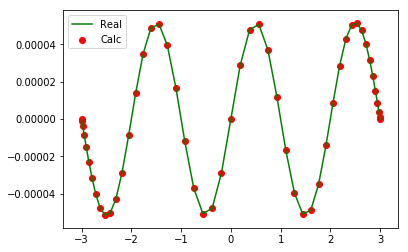

Number of time points    :     1000
Number of spatial points :       51
Error (relative norm)    : 3.61e-10    
Total time (sec)         : 2.44e-02    


In [4]:
_time = time.time()

IT = Intertrain(n=[x_poi], l=[[x_min, x_max]])
X = IT.grid()
T = np.linspace(t_min, t_max, t_poi)
h = (t_max - t_min) / (t_poi - 1)
D = IT.dif2()
J = np.eye(x_poi); J[0, 0] = 0.; J[-1, -1] = 0.
Z = expm(h * J @ D) @ J

r = func_r0(X)
for t in T[1:]:
    r = Z@r

_time = time.time() - _time
    
t = t_max
x = X.reshape(-1)
q = func_rt(X, t)
e = np.linalg.norm(q - r) / np.linalg.norm(q)

plt.plot(x, q, c='g', label='Real')
plt.scatter(x, r, c='r', label='Calc')
plt.legend(loc='best')
plt.show()

print('Number of time points    : %8d'%t_poi)
print('Number of spatial points : %8d'%IT.n[0])
print('Error (relative norm)    : %-12.2e'%e)
print('Total time (sec)         : %-12.2e'%_time)

<div class="head1">
    <div class="head1__name">
        Solution by the solver
    </div>
    <div class="head1__note">
        Since interpolation is not required for the case $f \equiv 0$, but our solver calculates it by design, then it is expected to operate much slower than explicit simple solver, which was presented above.
    </div>
</div>

In [5]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(t_poi, t_min, t_max)
SL.set_grid_x(x_poi, x_min, x_max)
SL.set_funcs(func_f0, func_f1, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()

Solve: 100%|███████| 999/999 [00:10<00:00, 91.43step/s, Norm 2.41e-04]


In [6]:
SL.info()

---------- Solver
Format   : 1D, NP
Grid x   : poi =        51, min =   -3.0000, max =    3.0000
Grid t   : poi =      1000, min =    0.0000, max =    1.0000
Time sec : prep = 6.78e-03, calc = 6.99e+00


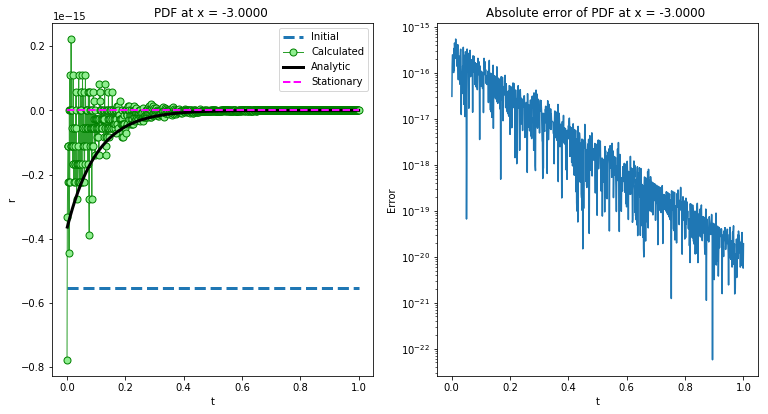

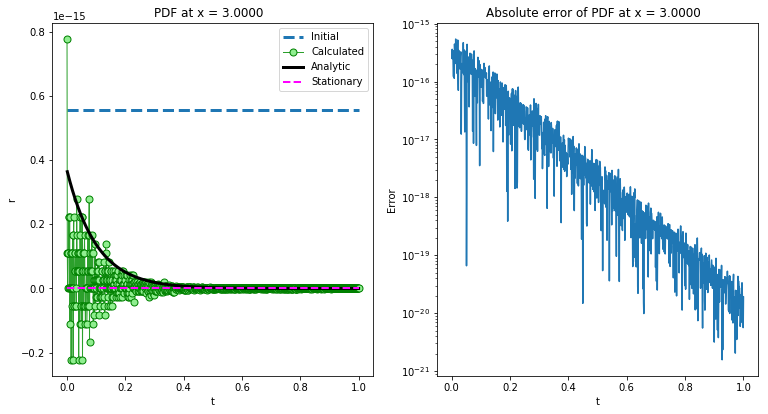

In [7]:
SL.plot_t(x=-3.0, is_err_abs=True)
SL.plot_t(x=+3.0, is_err_abs=True)

**Note** <span style="color: green;">Solution is zero near the boundaries as expected.<span>

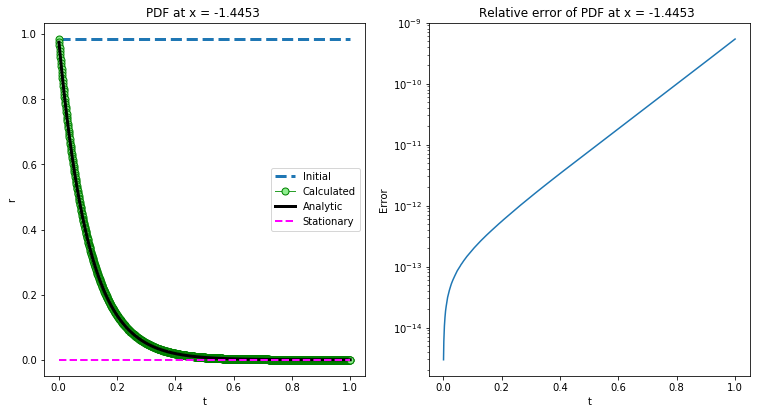

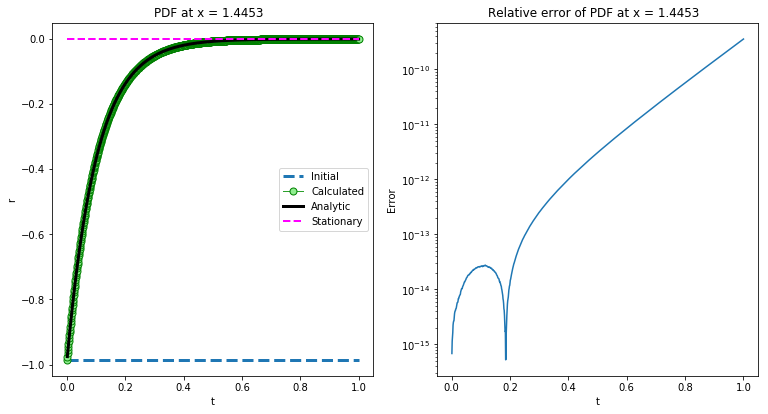

In [8]:
SL.plot_t(x=-1.5)
SL.plot_t(x=+1.5)

**Note** <span style="color: green;">Solution is very accurate.<span>

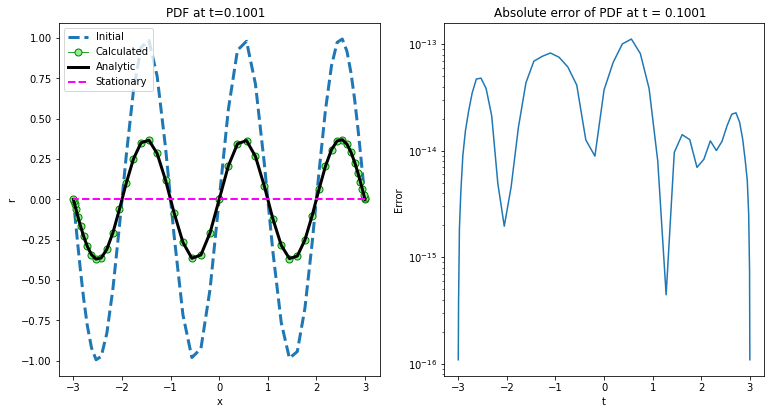

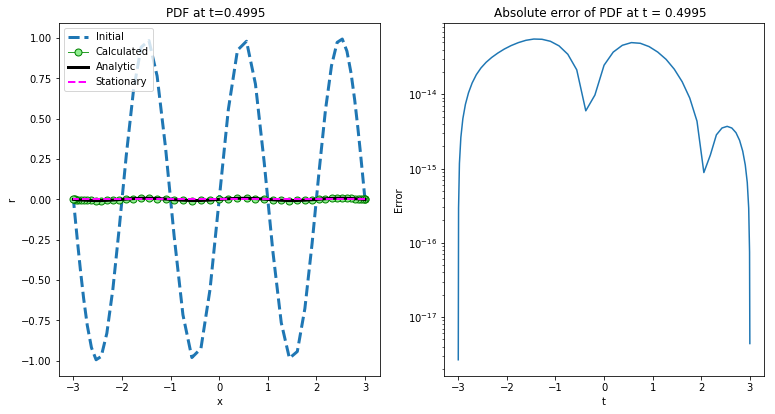

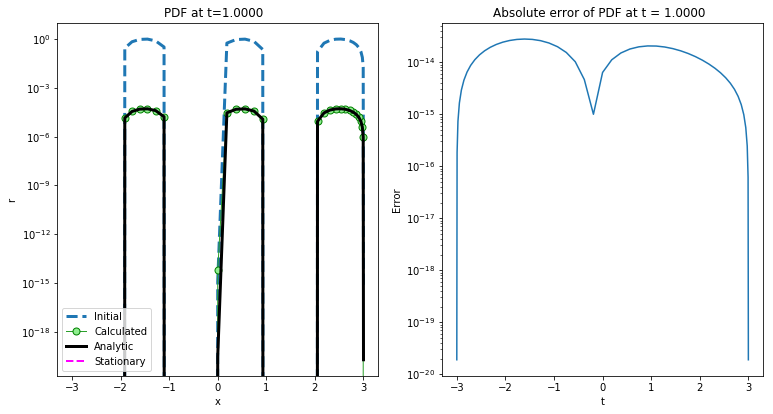

In [9]:
SL.plot_x(t=0.1, is_err_abs=True)
SL.plot_x(t=0.5, is_err_abs=True)
SL.plot_x(is_log=True, is_err_abs=True)

**Note** <span style="color: green;">Solution is very accurate.<span>

**Conclusion** <span style="color: blue;">As we can see, for diffusion process without drift term, our solver works absolutely correct.<span>

<div class="end"></div>